In [0]:
! wget -q https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
! wget -q https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
! wget -q https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
! gunzip -k cc.en.300.bin.gz

In [0]:
! pip install --upgrade razdel allennlp torch fasttext OpenNMT-py networkx pymorphy2 nltk rouge==0.3.1 summa sentencepiece==0.1.8 transformers

In [0]:
import copy
import math
import json
import os
import random
import time

from itertools import combinations
from collections import Counter, namedtuple
from typing import List, Tuple

import razdel
import pymorphy2
import fasttext

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack

from rouge import Rouge
from summa.summarizer import summarize
from sentencepiece import SentencePieceTrainer
from sentencepiece import SentencePieceProcessor
from nltk.translate.bleu_score import corpus_bleu
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

# EDA

## Data structure

In [2]:
! head -n 1 gazeta_train.txt
! cat gazeta_train.txt | wc -l
! cat gazeta_val.txt | wc -l
! cat gazeta_test.txt | wc -l

{"url": "https://www.gazeta.ru/financial/2011/11/30/3852658.shtml", "text": "«По итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. При этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «Интерфаксу» замминистра экономического развития Андрей Клепач. Официальные прогнозы по выводу капитала из России становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре Минэкономразвития назвал цифру $50 млрд, в начале ноября Центробанк пересмотрел оценку до $70 млрд. Очередное изменение прогноза было ожидаемо: по расчетам Центробанка , за январь — октябрь чистый отток капитала достиг $64 млрд, причем в последние месяцы он ускорился: в сентябре он составил $14 млрд, в октябре — $13 млрд против среднего ежемесячного оттока в $6—8 млрд в первом полугодии. «После октябрьских данных Минэкономразвития вынуждено было изменить оценку, настаивать на $70 млрд означало ожида

In [0]:
def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date

    records = []
    with open(file_name, "r") as r:
        for line in r:
            records.append(json.loads(line))

    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle

    return records

In [0]:
train_records = read_gazeta_records("gazeta_train.txt")
val_records = read_gazeta_records("gazeta_val.txt")
test_records = read_gazeta_records("gazeta_test.txt")

In [7]:
print(min([record["date"] for record in train_records]))
print(max([record["date"] for record in train_records]))
print(min([record["date"] for record in val_records]))
print(max([record["date"] for record in val_records]))
print(min([record["date"] for record in test_records]))
print(max([record["date"] for record in test_records]))

2010-06-01 10:35:49
2019-05-31 23:56:26
2019-06-01 08:30:00
2019-09-30 23:11:23
2019-10-01 08:23:02
2020-03-23 22:16:23


## Statistics

In [0]:
Stats = namedtuple("Stats", "vocabulary,lemma_vocabulary,words_counts,unique_words_counts")

def collect_stats(records, lower=True, text_max_words=3000, summary_max_words=100, nrows=1000):
    morph = pymorphy2.MorphAnalyzer()
    
    text_stats = Stats(Counter(),  Counter(), list(), list())
    summary_stats = Stats(Counter(),  Counter(), list(), list())

    def update_record_field_stats(field, stats, max_words):
        words = [word.text for word in razdel.tokenize(field)][:max_words]

        lemmas = [morph.parse(word)[0].normal_form for word in words]
        stats.vocabulary.update(words)
        stats.lemma_vocabulary.update(lemmas)
        stats.words_counts.append(len(words))
        stats.unique_words_counts.append(len(set(words)))

    for i, record in enumerate(records):
        if i >= nrows:
            break

        text = record["text"]
        text = text if not lower else text.lower()
        update_record_field_stats(text, text_stats, text_max_words)

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        summary_words = [word.text for word in razdel.tokenize(summary)]
        update_record_field_stats(summary, summary_stats, summary_max_words)

    return text_stats, summary_stats

In [9]:
test_text_stats, test_summary_stats = collect_stats(test_records)
common_lemmas = set(test_text_stats.lemma_vocabulary.keys()) & set(test_summary_stats.lemma_vocabulary.keys())

print("Test texts vocabulary size: ", len(test_text_stats.vocabulary))
print("Test texts lemma vocabulary size: ", len(test_text_stats.lemma_vocabulary))
print("Test summaries vocabulary size: ", len(test_summary_stats.vocabulary))
print("Test summaries lemma vocabulary size: ", len(test_summary_stats.lemma_vocabulary))
print("Test common lemmas summary vs text: ", len(common_lemmas))

Test texts vocabulary size:  73282
Test texts lemma vocabulary size:  32752
Test summaries vocabulary size:  15196
Test summaries lemma vocabulary size:  8673
Test common lemmas summary vs text:  8408


In [10]:
test_text_stats.lemma_vocabulary.most_common(25)

[(',', 54104),
 ('.', 38406),
 ('в', 28069),
 ('и', 14555),
 ('«', 12789),
 ('»', 12716),
 ('на', 11741),
 ('что', 9225),
 ('—', 8528),
 ('с', 8173),
 ('не', 7279),
 ('по', 6354),
 ('быть', 6232),
 ('он', 6206),
 ('это', 5730),
 ('год', 4998),
 ('который', 3920),
 ('о', 3888),
 ('тот', 3200),
 ('как', 2981),
 ('из', 2868),
 ('к', 2828),
 ('россия', 2713),
 ('она', 2659),
 ('они', 2632)]

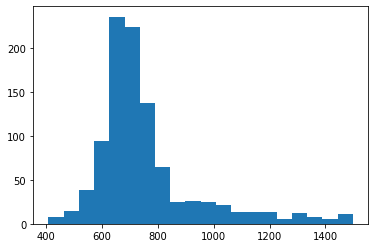

In [11]:
plt.hist(test_text_stats.words_counts, 20)
plt.show()

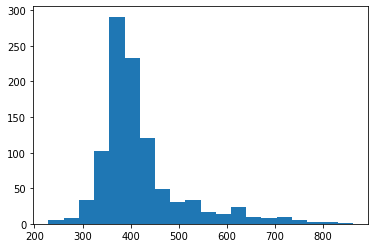

In [12]:
plt.hist(test_text_stats.unique_words_counts, 20)
plt.show()

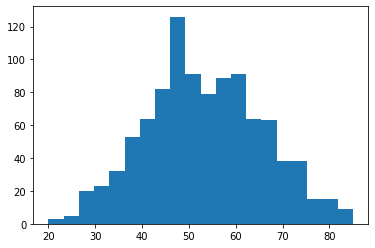

In [13]:
plt.hist(test_summary_stats.words_counts, 20)
plt.show()

In [14]:
train_text_stats, train_summary_stats = collect_stats(train_records)
common_lemmas = set(train_text_stats.lemma_vocabulary.keys()) & set(train_summary_stats.lemma_vocabulary.keys())

print("Train texts vocabulary size: ", len(train_text_stats.vocabulary))
print("Train texts lemma vocabulary size: ", len(train_text_stats.lemma_vocabulary))
print("Train summaries vocabulary size: ", len(train_summary_stats.vocabulary))
print("Train summaries lemma vocabulary size: ", len(train_summary_stats.lemma_vocabulary))
print("Train common lemmas summary vs text: ", len(common_lemmas))

Train texts vocabulary size:  82978
Train texts lemma vocabulary size:  38089
Train summaries vocabulary size:  15441
Train summaries lemma vocabulary size:  9087
Train common lemmas summary vs text:  8703


In [15]:
common_lemmas = set(train_text_stats.lemma_vocabulary.keys()) & set(test_text_stats.lemma_vocabulary.keys())
print("Text common lemmas train vs test: ", len(common_lemmas))

common_lemmas = set(train_summary_stats.lemma_vocabulary.keys()) & set(test_summary_stats.lemma_vocabulary.keys())
print("Summary common lemmas train vs test: ", len(common_lemmas))

Text common lemmas train vs test:  18875
Summary common lemmas train vs test:  4508


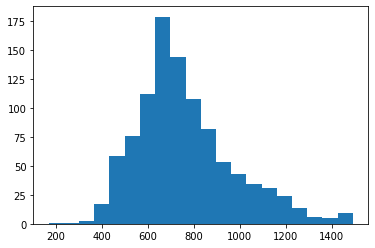

In [16]:
plt.hist(train_text_stats.words_counts, 20)
plt.show()

# Lead-3

In [0]:
def calc_scores(references, predictions, metric="all"):
    print("Count:", len(predictions))
    print("Ref:", references[-1])
    print("Hyp:", predictions[-1])

    if metric in ("bleu", "all"):
        print("BLEU: ", corpus_bleu([[r] for r in references], predictions))
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(predictions, references, avg=True)
        print("ROUGE: ", scores)

In [6]:
def calc_lead_n_score(records, n=3, lower=True, nrows=1000):
    references = []
    predictions = []

    for i, record in enumerate(records):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        text = text if not lower else text.lower()
        sentences = [sentence.text for sentence in razdel.sentenize(text)]
        prediction = " ".join(sentences[:n])
        predictions.append(prediction)

    calc_scores(references, predictions)

calc_lead_n_score(test_records, n=1)

Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: православный телеканал «спас», учредителем которого является московская патриархия, запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер в тверской области.
BLEU:  0.19177311186434495
ROUGE:  {'rouge-1': {'f': 0.23804097238957525, 'p': 0.22208274285774904, 'r': 0.37762764047433917}, 'rouge-2': {'f': 0.10027796832321115, 'p': 0.09647636782929753, 'r': 0.15833772153385062}, 'rouge-l': {'f': 0.1835646488408507, 'p': 0.2022959168891477, 'r': 0.34937017731940756}}


# TextRank

In [7]:
def unique_words_similarity(words1, words2):
    """
    Function for calculating similarity of sentences based on the intersection of words
    """
    words1 = set(words1)
    words2 = set(words2)

    if not len(words1) or not len(words2):
        return 0.0

    return len(words1.intersection(words2))/(np.log10(len(words1)) + np.log10(len(words2)))

def gen_text_rank_summary(text, calc_similarity=unique_words_similarity, summary_part=0.1, lower=True, morph=None):
    """
    Creating a summary using TextRank
    """
    # Split text into sentences
    sentences = [sentence.text for sentence in razdel.sentenize(text)]
    n_sentences = len(sentences)

    # Tokenization
    sentences_words = [
        [token.text.lower() if lower else token.text for token in razdel.tokenize(sentence)]
        for sentence in sentences
    ]

    # Lemmatization
    if morph is not None:
        sentences_words = [[morph.parse(word)[0].normal_form for word in words] for words in sentences_words]

    # Calculate sentence similarity for each pair of sentences
    pairs = combinations(range(n_sentences), 2)
    scores = [(i, j, calc_similarity(sentences_words[i], sentences_words[j])) for i, j in pairs]

    # Create a graph with weights on edges equal to sentence similarities
    g = nx.Graph()
    g.add_weighted_edges_from(scores)

    # Calculate PageRank
    pr = nx.pagerank(g)
    result = [(i, pr[i], s) for i, s in enumerate(sentences) if i in pr]
    result.sort(key=lambda x: x[1], reverse=True)

    # Select top sentences
    n_summary_sentences = max(int(n_sentences * summary_part), 1)
    result = result[:n_summary_sentences]

    # Recreate their original order
    result.sort(key=lambda x: x[0])

    # Recreate summary
    predicted_summary = " ".join([sentence for i, proba, sentence in result])
    predicted_summary = predicted_summary.lower() if lower else predicted_summary

    return predicted_summary

def calc_text_rank_score(
    records,
    calc_similarity=unique_words_similarity,
    summary_part=0.1,
    lower=True,
    nrows=1000,
    morph=None,
):
    references = []
    predictions = []

    for i, record in enumerate(records):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        predicted_summary = gen_text_rank_summary(text, calc_similarity, summary_part, lower, morph=morph)
        text = text if not lower else text.lower()
        predictions.append(predicted_summary)

    calc_scores(references, predictions)

morph = pymorphy2.MorphAnalyzer()
calc_text_rank_score(test_records)
calc_text_rank_score(test_records, morph=morph)

Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: православный телеканал «спас», учредителем которого является московская патриархия, запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер в тверской области. проживи месяц в ниловой пустыни, выполняя послушания, и найди ответы на вопросы, которые давно беспокоят», — так анонсирует телеканал свой проект. в июне нынешнего года сообщалось, что рпц планирует сделать из сергиева посада «православный ватикан». по его словам, такая зависимость сродни алкогольной или наркотической — электронные устройства лишают человека свободы и приводят к «дегумани

# Task 1

Change sentence similarity function in TextRank algorithm

In [0]:
ft = fasttext.load_model("cc.en.300.bin")

In [0]:
def fasttext_similarity(words1, words2):
    emb1, emb2 = [], []

    for word in words1:
        emb1.append(ft.get_word_vector(word))
    for word in words2:
        emb2.append(ft.get_word_vector(word))

    emb1 = np.mean(np.array(emb1), axis=0).reshape(1, -1)
    emb2 = np.mean(np.array(emb2), axis=0).reshape(1, -1)

    return cosine_similarity(emb1, emb2)

In [19]:
morph = pymorphy2.MorphAnalyzer()
calc_text_rank_score(test_records, calc_similarity=fasttext_similarity)
calc_text_rank_score(test_records, calc_similarity=fasttext_similarity, morph=morph)

Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: проживи месяц в ниловой пустыни, выполняя послушания, и найди ответы на вопросы, которые давно беспокоят», — так анонсирует телеканал свой проект. смирнов порассуждал, как можно допиться до «такой черной тоски, когда душа уже в аду», после чего заговорил о футболе. «если человеку невоцерковленному, далекому от церкви, в двух словах сказать, для чего нужна церковь — церковь… нужна для того, чтобы был силен дух нашего народа», — говорил предстоятель. по его словам, такая зависимость сродни алкогольной или наркотической — электронные устройства лишают человека свободы и приводят к «дегуманизации» личности, уводя в вирту

# Summa

In [20]:
def calc_summa_score(records, summary_part=0.1, lower=True, nrows=1000):
    references = []
    predictions = []

    for i, record in enumerate(records):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        text = text if not lower else text.lower()
        predicted_summary = summarize(text, ratio=summary_part, language='russian').replace("\n", " ")
        predictions.append(predicted_summary)

    calc_scores(references, predictions)

calc_summa_score(test_records)

Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: проживи месяц в ниловой пустыни, выполняя послушания, и найди ответы на вопросы, которые давно беспокоят», — так анонсирует телеканал свой проект. «у нас же даже многие журналисты не знают и не понимают многого, связанного с религиозными ценностями, а здесь — попытка обратить их внимание на это, может быть, им будет интересно. стоит отметить, что участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека. и это что — жизнь, что ли?
BLEU:  0.2762958192799957
ROUGE:  {'rouge-1': {'f': 0.1770425497877709, 'p': 0.14391909693539454, 'r': 0.247378763312854

# Oracle summary

To solve this problem as an extractive summarization problem, we first need to select those sentences from the original text, that are most similar to the summary based on out metrics.

In [0]:
def build_oracle_summary_greedy(text, gold_summary, calc_score, lower=True, max_sentences=30):
    """
    Gready oracle summary
    """
    gold_summary = gold_summary.lower() if lower else gold_summary

    # Split text into sentences
    sentences = [
        sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)
    ][:max_sentences]
    n_sentences = len(sentences)

    oracle_summary_sentences = set()
    score = -1.0
    summaries = []
    for _ in range(n_sentences):
        for i in range(n_sentences):
            if i in oracle_summary_sentences:
                continue
            current_summary_sentences = copy.copy(oracle_summary_sentences)

            # Add new sentence to already constructured summary
            current_summary_sentences.add(i)
            current_summary = " ".join([sentences[index] for index in sorted(list(current_summary_sentences))])

            # Calculate metrics
            current_score = calc_score(current_summary, gold_summary)
            summaries.append((current_score, current_summary_sentences))

        # If metrics were improved, try to add new sentences
        # Otherwise, terminate
        best_summary_score, best_summary_sentences = max(summaries)
        if best_summary_score <= score:
            break

        oracle_summary_sentences = best_summary_sentences
        score = best_summary_score

    oracle_summary = " ".join([sentences[index] for index in sorted(list(oracle_summary_sentences))])

    return oracle_summary, oracle_summary_sentences


def calc_single_score(pred_summary, gold_summary, rouge):
    return rouge.get_scores([pred_summary], [gold_summary], avg=True)["rouge-2"]["f"]

In [22]:
def calc_oracle_score(records, nrows=1000, lower=True):
    references = []
    predictions = []
    rouge = Rouge()

    for i, record in enumerate(records):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        predicted_summary, _ = build_oracle_summary_greedy(
            text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge)
        )
        predictions.append(predicted_summary)

    calc_scores(references, predictions)

calc_oracle_score(test_records)

Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: православный телеканал «спас», учредителем которого является московская патриархия, запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер в тверской области. в комментарии также отмечается, что это беспрецедентный подобный проект на телевидении. стоит отметить, что участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
BLEU:  0.531336150784986
ROUGE:  {'rouge-1': {'f': 0.36951810858804146, 'p': 0.4053281117404892, 'r': 0.3661389123393327}, 'rouge-2': {'f': 0.2087846693590

# Extractive RNN

## BPE

In [0]:
def train_bpe(records, model_path, model_type="bpe", vocab_size=15000, lower=True):
    temp_file_name = "temp.txt"

    with open(temp_file_name, "w") as temp:
        for record in train_records:
            summary = record["summary"].strip()
            text = record["text"].strip()

            if lower:
                summary = summary.lower()
                text = text.lower()
            if not text or not summary:
                continue

            temp.write(text + "\n")
            temp.write(summary + "\n")

    if not os.path.exists(model_path):
        os.makedirs(model_path)

    cmd = "--input={} --model_prefix={} --vocab_size={} --model_type={}".format(
        temp_file_name,
        os.path.join(model_path, model_type),
        vocab_size,
        model_type)

    SentencePieceTrainer.Train(cmd)

In [0]:
! rm -f bpe.model
! rm -f bpe.vocab

In [0]:
train_bpe(train_records, "./")

In [8]:
! head bpe.vocab
! cat bpe.vocab | wc -l

<unk>	0
<s>	0
</s>	0
▁п	-0
▁с	-1
▁в	-2
ро	-3
ст	-4
ра	-5
на	-6
15000


In [9]:
bpe_processor = SentencePieceProcessor()
bpe_processor.Load("bpe.model")

def bpe_tokenize(text, bpe_processor):
    return bpe_processor.EncodeAsPieces(text)

bpe_tokenize("октябрь богат на изменения", bpe_processor)

['▁октябрь', '▁бога', 'т', '▁на', '▁изменения']

## Vocabulary

In [0]:
class Vocabulary:
    def __init__(self):
        self.index2word = list()
        self.word2index = dict()
        self.word2count = Counter()
        self.reset()

    def get_pad(self):
        return self.word2index["<pad>"]

    def get_sos(self):
        return self.word2index["<sos>"]

    def get_eos(self):
        return self.word2index["<eos>"]

    def get_unk(self):
        return self.word2index["<unk>"]

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = len(self.index2word)
            self.word2count[word] += 1
            self.index2word.append(word)
        else:
            self.word2count[word] += 1
    
    def has_word(self, word) -> bool:
        return word in self.word2index

    def get_index(self, word):
        if word in self.word2index:
            return self.word2index[word]
        return self.get_unk()

    def get_word(self, index):
        return self.index2word[index]

    def size(self):
        return len(self.index2word)

    def is_empty(self):
        empty_size = 4
        return self.size() <= empty_size

    def shrink(self, n):
        best_words = self.word2count.most_common(n)
        self.reset()
        for word, count in best_words:
            self.add_word(word)
            self.word2count[word] = count

    def reset(self):
        self.word2count = Counter()
        self.index2word = ["<pad>", "<sos>", "<eos>", "<unk>"]
        self.word2index = {word: index for index, word in enumerate(self.index2word)}

In [11]:
def build_vocabulary(records, bpe_processor, lower=True): 
    vocabulary = Vocabulary()

    for record in records:
        text = record["text"]
        text = text.lower() if lower else text
        tokens = bpe_tokenize(text, bpe_processor)

        for token in tokens:
            vocabulary.add_word(token)

    return vocabulary

vocabulary = build_vocabulary(train_records, bpe_processor)
print(vocabulary.word2count.most_common(25)) 

[(',', 2467870), ('.', 1770601), ('▁в', 1432966), ('▁и', 856627), ('▁«', 769136), ('▁на', 667157), ('▁не', 458901), ('▁—', 423218), ('▁с', 407759), ('▁что', 399348), ('▁по', 355321), ('»', 349402), ('-', 299470), ('»,', 239006), ('▁за', 198471), ('▁а', 198254), ('▁из', 182499), ('».', 172453), ('▁о', 164747), ('▁к', 163134), ('▁у', 146741), ('▁от', 143396), ('▁но', 141837), ('▁как', 135981), ('ли', 128134)]


## Cache

In [0]:
# def add_oracle_summary_to_records(records, max_sentences=30, lower=True, nrows=1000):
#     rouge = Rouge()

#     for i, record in enumerate(records):
#         if i >= nrows:
#             break

#         if i % 128 == 0:
#             print(i)

#         text = record["text"]
#         summary = record["summary"]
#         summary = summary.lower() if lower else summary
#         sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
#         oracle_summary, sentences_indicies = build_oracle_summary_greedy(
#             text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge), lower=lower, max_sentences=max_sentences
#         )
#         record["sentences"] = sentences
#         record["oracle_sentences"] = list(sentences_indicies)
#         record["oracle_summary"] = oracle_summary

#     return records[:nrows]

# ext_train_records = add_oracle_summary_to_records(train_records, nrows=16384)
# ext_val_records = add_oracle_summary_to_records(val_records, nrows=1024)
# ext_test_records = add_oracle_summary_to_records(test_records, nrows=1024)

In [0]:
# def write_gazeta_records(records, file_name):
#     with open(file_name, "w") as w:
#         for record in records:
#             record["oracle_sentences"] = list(record["oracle_sentences"])
#             w.write(json.dumps(record, ensure_ascii=False).strip() + "\n")

# write_gazeta_records(ext_train_records, "gazeta_train_with_oracle.txt")
# write_gazeta_records(ext_val_records, "gazeta_val_with_oracle.txt")
# write_gazeta_records(ext_test_records, "gazeta_test_with_oracle.txt")

In [0]:
# !cp "gazeta_train_with_oracle.txt" "drive/My Drive/gazeta_train_with_oracle.txt"
# !cp "gazeta_val_with_oracle.txt" "drive/My Drive/gazeta_val_with_oracle.txt"
# !cp "gazeta_test_with_oracle.txt" "drive/My Drive/gazeta_test_with_oracle.txt"

In [0]:
# !cp "drive/My Drive/gazeta_train_with_oracle.txt" "gazeta_train_with_oracle.txt"
# !cp "drive/My Drive/gazeta_val_with_oracle.txt" "gazeta_val_with_oracle.txt"
# !cp "drive/My Drive/gazeta_test_with_oracle.txt" "gazeta_test_with_oracle.txt"

In [0]:
ext_train_records = read_gazeta_records("gazeta_train_with_oracle.txt")
ext_val_records = read_gazeta_records("gazeta_val_with_oracle.txt")
ext_test_records = read_gazeta_records("gazeta_test_with_oracle.txt")

## Batch Iterator

In [0]:
class BatchIterator():
    def __init__(
        self,
        records,
        vocabulary,
        batch_size,
        bpe_processor,
        shuffle=True,
        lower=True,
        max_sentences=30,
        max_sentence_length=50,
        device=torch.device("cpu")
    ):
        self.records = records
        self.num_samples = len(records)
        self.batch_size = batch_size
        self.bpe_processor = bpe_processor
        self.shuffle = shuffle
        self.batches_count = int(math.ceil(self.num_samples / batch_size))
        self.lower = lower
        self.rouge = Rouge()
        self.vocabulary = vocabulary
        self.max_sentences = max_sentences
        self.max_sentence_length = max_sentence_length
        self.device = device

    def __len__(self):
        return self.batches_count

    def __iter__(self):
        indices = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(indices)

        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)
            batch_indices = indices[start:end]
            batch_inputs = []
            batch_outputs = []
            max_sentence_length = 0
            max_sentences = 0
            batch_records = []

            for data_ind in batch_indices:
                record = self.records[data_ind]
                batch_records.append(record)
                text = record["text"]
                summary = record["summary"]
                summary = summary.lower() if self.lower else summary

                if "sentences" not in record:
                    sentences = [
                        sentence.text.lower() if self.lower else sentence.text for sentence in razdel.sentenize(text)
                    ][:self.max_sentences]
                else:
                    sentences = record["sentences"]
                max_sentences = max(len(sentences), max_sentences)

                if "oracle_sentences" not in record:
                    calc_score = lambda x, y: calc_single_score(x, y, self.rouge)
                    sentences_indicies = build_oracle_summary_greedy(
                        text, summary, calc_score=calc_score, lower=self.lower, max_sentences=self.max_sentences
                    )[1]
                else:
                    sentences_indicies = record["oracle_sentences"]

                inputs = [
                    list(map(
                        self.vocabulary.get_index,
                        bpe_tokenize(sentence, self.bpe_processor)[:self.max_sentence_length]
                    ))
                    for sentence in sentences
                ]
                max_sentence_length = max(max_sentence_length, max([len(tokens) for tokens in inputs]))
                outputs = [int(i in sentences_indicies) for i in range(len(sentences))]
                batch_inputs.append(inputs)
                batch_outputs.append(outputs)
            tensor_inputs = torch.zeros(
                (self.batch_size, max_sentences, max_sentence_length), dtype=torch.long, device=self.device
            )
            tensor_outputs = torch.zeros(
                (self.batch_size, max_sentences), dtype=torch.float32, device=self.device
            )
            for i, inputs in enumerate(batch_inputs):
                for j, sentence_tokens in enumerate(inputs):
                    tensor_inputs[i][j][:len(sentence_tokens)] = torch.LongTensor(sentence_tokens)
            for i, outputs in enumerate(batch_outputs):
                tensor_outputs[i][:len(outputs)] = torch.LongTensor(outputs)

            yield {
                "inputs": tensor_inputs,
                "outputs": tensor_outputs,
                "records": batch_records
            }

## Training

In [0]:
def train_model(
    model,
    train_records,
    val_records,
    vocabulary,
    bpe_processor,
    batch_size=32,
    epochs_count=10,
    loss_every_nsteps=16,
    lr=0.001,
    device_name="cuda",
):
    params_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Trainable params: {}".format(params_count))

    device = torch.device(device_name)
    model = model.to(device)
    total_loss = 0
    start_time = time.time()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.BCEWithLogitsLoss().to(device)

    for epoch in range(epochs_count):
        train_iter = BatchIterator(train_records, vocabulary, batch_size, bpe_processor, device=device)
        val_iter = BatchIterator(val_records, vocabulary, batch_size, bpe_processor, device=device)

        for step, batch in enumerate(train_iter):
            model.train()

            logits = model(batch["inputs"])

            loss = loss_function(logits, batch["outputs"])
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item()

            if step % loss_every_nsteps == 0 and step != 0:
                val_total_loss = 0
                val_batch_count = 0

                model.eval()

                for _, val_batch in enumerate(val_iter):
                    logits = model(val_batch["inputs"])
                    val_total_loss += loss_function(logits, batch["outputs"])
                    val_batch_count += 1

                avg_val_loss = val_total_loss/val_batch_count
                print(
                    "Epoch = {}, Avg Train Loss = {:.4f}, Avg val loss = {:.4f}, Time = {:.2f}s" \
                    .format(epoch, total_loss / loss_every_nsteps, avg_val_loss, time.time() - start_time)
                )

                total_loss = 0
                start_time = time.time()

        print("\n")

        total_loss = 0
        start_time = time.time()

In [24]:
class SentenceEncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, n_layers=3, dropout=0.3, bidirectional=True):
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.embedding_dim = embedding_dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.embedding_layer = nn.Embedding(input_size, embedding_dim)
        self.rnn_layer = nn.LSTM(
            embedding_dim,
            hidden_size,
            n_layers,
            dropout=dropout,
            bidirectional=bidirectional,
            batch_first=True
        )
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, inputs, hidden=None):
        embedded = self.embedding_layer(inputs)
        outputs, _ = self.rnn_layer(embedded, hidden)
        sentences_embeddings = torch.mean(outputs, 1)

        return sentences_embeddings

class SentenceTaggerRNN(nn.Module):
    def __init__(
        self,
        vocabulary_size,
        token_embedding_dim=256,
        sentence_encoder_hidden_size=256,
        hidden_size=256,
        bidirectional=True,
        sentence_encoder_n_layers=2,
        sentence_encoder_dropout=0.3,
        sentence_encoder_bidirectional=True,
        n_layers=1,
        dropout=0.3,
    ):
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.sentence_encoder = SentenceEncoderRNN(
            vocabulary_size,
            token_embedding_dim,
            sentence_encoder_hidden_size,
            sentence_encoder_n_layers,
            sentence_encoder_dropout,
            sentence_encoder_bidirectional
        )
        self.rnn_layer = nn.LSTM(
            sentence_encoder_hidden_size,
            hidden_size,
            n_layers,
            dropout=dropout,
            bidirectional=bidirectional,
            batch_first=True
        )
        self.dropout_layer = nn.Dropout(dropout)
        self.content_linear_layer = nn.Linear(hidden_size * 2, 1)
        self.document_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.salience_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.tanh_layer = nn.Tanh()

    def forward(self, inputs, hidden=None):
        batch_size = inputs.size(0)
        sentences_count = inputs.size(1)
        tokens_count = inputs.size(2)
        inputs = inputs.reshape(-1, tokens_count)
        embedded_sentences = self.sentence_encoder(inputs)
        embedded_sentences = embedded_sentences.reshape(batch_size, sentences_count, -1)
        outputs, _ = self.rnn_layer(embedded_sentences, hidden)
        outputs = self.dropout_layer(outputs)
        document_embedding = self.tanh_layer(self.document_linear_layer(torch.mean(outputs, 1)))
        content = self.content_linear_layer(outputs).squeeze(2)
        salience = torch.bmm(outputs, self.salience_linear_layer(document_embedding).unsqueeze(2)).squeeze(2)

        return content + salience

model = SentenceTaggerRNN(vocabulary.size())
train_model(
    model,
    ext_train_records,
    ext_val_records,
    vocabulary,
    bpe_processor,
    device_name="cuda",
    batch_size=32,
    epochs_count=4,
    loss_every_nsteps=100
)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Trainable params: 5250305
Epoch = 0, Avg Train Loss = 0.2571, Avg val loss = 0.2533, Time = 26.08s
Epoch = 0, Avg Train Loss = 0.2318, Avg val loss = 0.2639, Time = 25.59s
Epoch = 0, Avg Train Loss = 0.2288, Avg val loss = 0.2238, Time = 25.87s
Epoch = 0, Avg Train Loss = 0.2272, Avg val loss = 0.2499, Time = 25.72s
Epoch = 0, Avg Train Loss = 0.2234, Avg val loss = 0.2520, Time = 25.65s


Epoch = 1, Avg Train Loss = 0.2224, Avg val loss = 0.2564, Time = 25.77s
Epoch = 1, Avg Train Loss = 0.2158, Avg val loss = 0.2557, Time = 25.68s
Epoch = 1, Avg Train Loss = 0.2204, Avg val loss = 0.2192, Time = 25.67s
Epoch = 1, Avg Train Loss = 0.2181, Avg val loss = 0.2734, Time = 25.51s
Epoch = 1, Avg Train Loss = 0.2183, Avg val loss = 0.2623, Time = 25.84s


Epoch = 2, Avg Train Loss = 0.2078, Avg val loss = 0.2379, Time = 25.74s
Epoch = 2, Avg Train Loss = 0.2063, Avg val loss = 0.2720, Time = 25.71s
Epoch = 2, Avg Train Loss = 0.2082, Avg val loss = 0.2870, Time = 25.69s
Epoch = 2, Avg Train 

In [25]:
device = torch.device("cuda")

references = []
predictions = []
for step, batch in enumerate(BatchIterator(ext_test_records, vocabulary, 32, bpe_processor, device=device)):
    logits = model(batch["inputs"])
    records = batch["records"]

    for record, record_logits in zip(records, logits):
        sentences = record["sentences"]

        predicted_summary = []
        for i, logit in enumerate(record_logits):
            if logit > 0.0:
                predicted_summary.append(sentences[i])

        if not predicted_summary:
            predicted_summary.append(sentences[torch.max(record_logits, dim=0)[1].item()])

        predicted_summary = " ".join(predicted_summary)
        references.append(record["summary"].lower())
        predictions.append(predicted_summary)

calc_scores(references, predictions)

Count: 1024
Ref: поп-исполнительница лана дель рей из-за болезни была вынуждена отменить тур по европе и великобритании. по несчастному совпадению, в это же время от своих ближайших выступлений были вынуждены отказаться британцы элтон джон и оззи озборн.
Hyp: американская певица лана дель рей отменила свой тур по европе и великобритании из-за болезни, которая привела к потери голоса, пишет variety.
BLEU:  0.2095700325102749
ROUGE:  {'rouge-1': {'f': 0.21692709565554935, 'p': 0.3375305655874032, 'r': 0.17181026476928488}, 'rouge-2': {'f': 0.09652137781110065, 'p': 0.1537783457326263, 'r': 0.07661630595190576}, 'rouge-l': {'f': 0.16347601644541387, 'p': 0.3032514812097066, 'r': 0.15353225018814678}}


## Task 2

Add missing parts of [SummaRuNNer](https://arxiv.org/pdf/1611.04230.pdf)

In [79]:
from torch.autograd import Variable
class SentenceEncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, n_layers=3, dropout=0.3, bidirectional=True):
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.embedding_dim = embedding_dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.embedding_layer = nn.Embedding(input_size, embedding_dim)
        self.rnn_layer = nn.LSTM(
            embedding_dim,
            hidden_size,
            n_layers,
            dropout=dropout,
            bidirectional=bidirectional,
            batch_first=True
        )
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, inputs, hidden=None):
        embedded = self.embedding_layer(inputs)
        outputs, _ = self.rnn_layer(embedded, hidden)
        sentences_embeddings = torch.mean(outputs, 1)

        return sentences_embeddings

class SentenceTaggerRNN(nn.Module):
    def __init__(
        self,
        vocabulary_size,
        token_embedding_dim=256,
        sentence_encoder_hidden_size=256,
        absolute_position_hidden_size=15,
        relative_position_hidden_size=15,
        relative_groups=5,
        hidden_size=256,
        bidirectional=True,
        sentence_encoder_n_layers=2,
        sentence_encoder_dropout=0.3,
        sentence_encoder_bidirectional=True,
        n_layers=1,
        dropout=0.3,
    ):
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        assert 30 % relative_groups == 0
        hidden_size = hidden_size // num_directions

        self.relative_groups = relative_groups
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.absolute_position_emb = nn.Embedding(30, absolute_position_hidden_size)
        self.relative_position_emb = nn.Embedding(30 // relative_groups, relative_position_hidden_size)

        self.sentence_encoder = SentenceEncoderRNN(
            vocabulary_size,
            token_embedding_dim,
            sentence_encoder_hidden_size,
            sentence_encoder_n_layers,
            sentence_encoder_dropout,
            sentence_encoder_bidirectional
        )
        self.rnn_layer = nn.LSTM(
            sentence_encoder_hidden_size,
            hidden_size,
            n_layers,
            dropout=dropout,
            bidirectional=bidirectional,
            batch_first=True
        )
        self.dropout_layer = nn.Dropout(dropout)
        self.content_linear_layer = nn.Linear(hidden_size * 2, 1)
        self.document_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.salience_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.absolute_position_layer = nn.Linear(absolute_position_hidden_size, 1)
        self.relative_position_layer = nn.Linear(relative_position_hidden_size, 1)
        self.novelty_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.tanh_layer = nn.Tanh()
        self.bias = nn.Parameter(torch.empty((32, 30)).uniform_(-0.1, 0.1))

    def forward(self, inputs, hidden=None):
        batch_size, sentences_count, tokens_count = inputs.shape

        inputs = inputs.reshape(-1, tokens_count)
        embedded_sentences = self.sentence_encoder(inputs)
        embedded_sentences = embedded_sentences.reshape(batch_size, sentences_count, -1)

        outputs, _ = self.rnn_layer(embedded_sentences, hidden)
        outputs = self.dropout_layer(outputs)

        document_embedding = self.tanh_layer(self.document_linear_layer(torch.mean(outputs, 1)))

        content = self.content_linear_layer(outputs).squeeze(2)

        salience = torch.bmm(outputs, self.salience_linear_layer(document_embedding).unsqueeze(2)).squeeze(2)

        abs_pos = np.array([np.arange(sentences_count) for _ in range(batch_size)])
        abs_pos = torch.from_numpy(abs_pos).cuda()
        abs_pos = self.absolute_position_layer(self.absolute_position_emb(abs_pos)).squeeze(2)

        rel_pos = np.array([np.arange(sentences_count) // self.relative_groups for _ in range(batch_size)])
        rel_pos = torch.from_numpy(rel_pos).cuda()
        rel_pos = self.relative_position_layer(self.relative_position_emb(rel_pos)).squeeze(2)

        out = content + salience + abs_pos + rel_pos + self.bias
     
        novelty = []
        for i in range(batch_size):
            tmp = []
            s = torch.zeros((1, outputs.shape[2])).cuda()

            for j in range(sentences_count):
                nov = self.novelty_linear_layer(self.tanh_layer(s)) @ outputs[i][j]
                s += outputs[i][j] * torch.sigmoid(out[i][j] - nov[0])
                tmp.append(nov)

            novelty.append(torch.cuda.FloatTensor(tmp))

        return out - torch.cat(novelty).view(batch_size, -1)

model = SentenceTaggerRNN(vocabulary.size())
train_model(
    model,
    ext_train_records,
    ext_val_records,
    vocabulary,
    bpe_processor,
    device_name="cuda",
    batch_size=32,
    epochs_count=5,
    loss_every_nsteps=16
)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Trainable params: 5317629
Epoch = 0, Avg Train Loss = 0.3628, Avg val loss = 0.2749, Time = 24.34s
Epoch = 0, Avg Train Loss = 0.2575, Avg val loss = 0.2905, Time = 23.82s
Epoch = 0, Avg Train Loss = 0.2538, Avg val loss = 0.2757, Time = 23.92s
Epoch = 0, Avg Train Loss = 0.2494, Avg val loss = 0.2444, Time = 23.91s
Epoch = 0, Avg Train Loss = 0.2406, Avg val loss = 0.2515, Time = 23.83s
Epoch = 0, Avg Train Loss = 0.2396, Avg val loss = 0.2658, Time = 24.04s
Epoch = 0, Avg Train Loss = 0.2300, Avg val loss = 0.2025, Time = 23.99s
Epoch = 0, Avg Train Loss = 0.2358, Avg val loss = 0.2474, Time = 24.24s
Epoch = 0, Avg Train Loss = 0.2415, Avg val loss = 0.2192, Time = 24.24s
Epoch = 0, Avg Train Loss = 0.2294, Avg val loss = 0.1945, Time = 24.26s
Epoch = 0, Avg Train Loss = 0.2295, Avg val loss = 0.2269, Time = 24.31s
Epoch = 0, Avg Train Loss = 0.2450, Avg val loss = 0.2581, Time = 24.10s
Epoch = 0, Avg Train Loss = 0.2279, Avg val loss = 0.2545, Time = 24.22s
Epoch = 0, Avg Train Loss

In [60]:
device = torch.device("cuda")

references = []
predictions = []
for step, batch in enumerate(BatchIterator(ext_test_records, vocabulary, 32, bpe_processor, device=device)):
    logits = model(batch["inputs"])
    records = batch["records"]

    for record, record_logits in zip(records, logits):
        sentences = record["sentences"]

        predicted_summary = []
        for i, logit in enumerate(record_logits):
            if logit > 0.0:
                predicted_summary.append(sentences[i])

        if not predicted_summary:
            predicted_summary.append(sentences[torch.max(record_logits, dim=0)[1].item()])

        predicted_summary = " ".join(predicted_summary)
        references.append(record["summary"].lower())
        predictions.append(predicted_summary)

calc_scores(references, predictions)

Count: 1024
Ref: компания apple продолжает осваивать все новые рынки — если верить инсайдерам, «яблоко» готовит к выпуску игровой компьютер, предназначенный специально для киберспортсменов. стоимость такого устройства предположительно составит $5 тыс., а увидеть его можно будет на презентации wwdc 2020 летом следующего года.
Hyp: компания apple , запустившая в этом году игровой сервис apple arcade, планирует продолжить свою экспансию на рынок гейминга.
BLEU:  0.24098685115950752
ROUGE:  {'rouge-1': {'f': 0.20366603549220438, 'p': 0.30138822885618005, 'r': 0.16871960242354342}, 'rouge-2': {'f': 0.08428669086759899, 'p': 0.126893012485077, 'r': 0.07016954171489367}, 'rouge-l': {'f': 0.15845245948232436, 'p': 0.273405996643831, 'r': 0.1523603019747474}}
